# **1.) Описание проекта**

## **Полезные материалы**


*   nnUnet (https://github.com/NVIDIA/DeepLearningExamples/tree/master/PyTorch/Segmentation/nnUNet)
*   SwinUNETR (https://docs.monai.io/en/stable/_modules/monai/networks/nets/swin_unetr.html)
*   MedNeXt (https://github.com/MIC-DKFZ/MedNeXt)



# **2.) Подготовка среды**

## **Установка необходимых библиотек**

In [ ]:
!pip install monai
!pip install 'monai[einops]'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 6.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

## **Подключение модулей**

In [ ]:
import os
import json
import shutil
import tempfile
import time
import sys
import glob
import random as rand

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

from typing import List, Tuple, Any, Dict, Union, Set, Callable, Iterable, TypeVar, OrderedDict

from monai import data
from monai import transforms
from monai.transforms import (
    Compose, LoadImageD, ScaleIntensityRangeD, ScaleIntensityRange,
    EnsureChannelFirstD, MapLabelValueD, AsDiscreteD, EnsureTypeD,
    Activations, CropForegroundd, RandSpatialCropd, RandFlipd,
    AsDiscrete, Activations, Resized, Resize, EnsureType, EnsureChannelFirst,
    LoadImage
)
from monai.networks.nets import SwinUNETR
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
import subprocess
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


# **3.) Реализация необходимых классов**

## **Assistant**

In [ ]:
class Assistant():
  def __init__(self, base_path: str, dataset_names: Dict, total_scans: Dict, total_slices: int):
    self.base_path = base_path
    self.dataset_names = dataset_names
    self.total_scans = total_scans
    self.total_slices = total_slices

  def normalize_image(self, img: np.array, min_val: int = -350, max_val: int = 400) -> np.array:
    img = np.clip(img, min_val, max_val)
    img -= min_val
    img /= (max_val - min_val)
    return img

  def show_slices(self, num_slices: int, suffixes: Dict, len_ind: int, ext: str, folders: Dict, norm: bool = False):
    ncols = 2
    nrows = num_slices
    for alias, dataset_name in self.dataset_names.items():
      fig, ax = plt.subplots(nrows = nrows, ncols = ncols, figsize=(ncols*5, nrows*6))
      fig.suptitle(f"{dataset_name} dataset", size=25, y=0.9)
      for i in  range(num_slices):
        ind = rand.randint(0, self.total_scans[alias] - 1)
        slice_ind = rand.randint(1, self.total_slices)
        img_name = alias + "_" + "id" + "0"*(len_ind-len(str(ind))) + str(ind) + "_slice" + str(slice_ind) + "_" + suffixes["images"] + ext
        lbl_name = alias + "_" + "id" + "0"*(len_ind-len(str(ind))) + str(ind) + "_slice" + str(slice_ind) + "_" + suffixes["labels"] + ext
        img_path = os.path.join(self.base_path, folders["images"], img_name)
        lbl_path = os.path.join(self.base_path, folders["labels"], lbl_name)
        img = np.load(img_path)
        lbl = np.load(lbl_path)
        if (norm):
          img = self.normalize_image(img)
        ax[i][0].imshow(img, cmap="gray")
        ax[i][0].axes.xaxis.set_ticks([]) # инициализация тиков и меток оси пустым списком
        ax[i][0].get_yaxis().set_visible(False)
        ax[i][0].set_xlabel(f"image_{ind}_{slice_ind}_{img.shape}", size=14)
        # ax[i][1].imshow(lbl, cmap="gray")
        ax[i][1].imshow(lbl)
        ax[i][1].axes.xaxis.set_ticks([]) # инициализация тиков и меток оси пустым списком
        ax[i][1].get_yaxis().set_visible(False)
        ax[i][1].set_xlabel(f"label_{ind}_{slice_ind}", size=14)
      plt.show()

  def create_split(self, split: Dict, folders: Dict, suffixes: Dict, json_name: str):
    images_path = os.path.join(self.base_path, folders["images"])
    labels_path = os.path.join(self.base_path, folders["labels"])
    image_names = os.listdir(images_path)
    rand.shuffle(image_names)
    total_nums = len(image_names)
    dataset_nums = {}
    for dataset, part in split.items():
      dataset_nums[dataset] = int(total_nums*part)
    dataset_data = {}
    last_ind = 0
    for dataset, nums in dataset_nums.items():
      dataset_data[dataset] = []
      for ind in range(last_ind, min(total_nums, last_ind + nums)):
        record = {}
        img_name = image_names[ind]
        lbl_name = img_name.replace(suffixes["images"], suffixes["labels"])
        img_path = os.path.join(images_path, img_name)
        lbl_path = os.path.join(labels_path, lbl_name)
        record["image"] = img_path
        record["label"] = lbl_path
        dataset_data[dataset].append(record)
      last_ind += nums
    json_path = os.path.join(self.base_path, json_name)
    with open(json_path, 'w') as jsonfile:
      json.dump(dataset_data, jsonfile)

  def read_dataset_json(self, json_name: str) -> Dict:
    json_path = os.path.join(self.base_path, json_name)
    with open(json_path) as f:
      json_data = json.load(f)
    return json_data

  def create_loaders(self, batch_size: int, json_name: str, transformations: Dict, n_classes: int, roi: Tuple, num_workers: int) -> Dict:
    files = self.read_dataset_json(json_name)

    transform = Compose([
      LoadImageD(keys=['image', 'label']),
      EnsureChannelFirstD(keys=['image', 'label']),
      # CropForegroundd(
      #           keys=["image", "label"],
      #           source_key="image",
      #           k_divisible=[roi[0], roi[1]],
      #       ),
      # RandSpatialCropd(
      #           keys=["image", "label"],
      #           roi_size=[roi[0], roi[1]],
      #           random_center = True,
      #           random_size=False,
      #       ),
      Resized(keys=['image', 'label'], spatial_size=[roi[0], roi[1]], mode = "nearest"),
      ScaleIntensityRangeD(keys='image', a_min=-350, a_max=400, b_min=0.0, b_max=1.0, clip=True),
      RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
      RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
      MapLabelValueD(keys='label', orig_labels = list(transformations.keys()), target_labels = list(transformations.values())),
      AsDiscreteD(keys='label', to_onehot = n_classes),
      EnsureTypeD(keys=['image', 'label'])
    ])

    loaders = {}
    for ds, ds_data in files.items():
      dataset = data.Dataset(data = ds_data, transform = transform)
      loaders[ds] = data.DataLoader(dataset, batch_size = batch_size, shuffle = True, num_workers = num_workers)
    return loaders

## **BCEDiceLoss**

In [ ]:
class BCEDiceLoss(nn.Module):
    def __init__(self):
        super(BCEDiceLoss, self).__init__()

    def forward(self, input, target):
        bce = F.binary_cross_entropy_with_logits(input, target)
        smooth = 1e-5
        input = torch.sigmoid(input)
        num = target.size(0)
        input = input.view(num, -1)
        target = target.view(num, -1)
        intersection = (input * target)
        dice = (2. * intersection.sum(1) + smooth) / (input.sum(1) + target.sum(1) + smooth)
        dice = 1 - dice.sum() / num
        return 0.5 * bce + dice

## **AverageMeter**

In [ ]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = np.where(self.count > 0, self.sum / self.count, self.sum)

## **Trainer**

In [ ]:
class Trainer():
  def __init__(self, model, device, model_name: str, path_weights: str = ""):
    self.model = model.to(device)
    self.model_name = model_name
    self.device = device
    if (path_weights != ""):
      self.model.load_state_dict(torch.load(path_weights)["state_dict"])

  def train_epoch(self, loader, optimizer, loss_func, acc_func, post_processing):
    losses = AverageMeter()
    dices = AverageMeter()
    self.model.train()
    # for idx, batch_data in tqdm(enumerate(loader), total=len(loader), bar_format='{l_bar}{bar}{r_bar}{remaining} s '):
    for idx, batch_data in tqdm(enumerate(loader), total=len(loader)):
      optimizer.zero_grad()
      imgs, targets = batch_data["image"].to(self.device), batch_data["label"].to(self.device)
      logits = self.model(imgs)
      loss = loss_func(logits, targets)
      losses.update(loss.item())

      acc_func.reset()
      acc_func(y_pred=post_processing(logits), y=targets)
      acc, not_nans = acc_func.aggregate()
      dices.update(val = acc.mean().cpu().numpy(), n = not_nans.sum().cpu().numpy())

      loss.backward()
      optimizer.step()

    log = OrderedDict([
      ('loss', losses.avg),
      ('dice', dices.avg),
    ])
    return log

  def val_epoch(self, loader, loss_func, acc_func, post_processing, get_predicts = False):
    self.model.eval()
    losses = AverageMeter()
    dices = AverageMeter()
    ind_pred = rand.randint(0, len(loader)-1)
    pred_arr = []
    img_arr = []
    target_arr = []
    print("\033[1mValidation\033[0m")
    with torch.no_grad():
      # for idx, batch_data in tqdm(enumerate(loader), total=len(loader), bar_format='{l_bar}{bar}{r_bar}{remaining} s '):
      for idx, batch_data in tqdm(enumerate(loader), total=len(loader)):
        imgs, targets = batch_data["image"].to(self.device), batch_data["label"].to(self.device)
        logits = self.model(imgs)
        loss = loss_func(logits, targets)
        losses.update(loss.item())

        acc_func.reset()
        acc_func(y_pred=post_processing(logits), y=targets)
        acc, not_nans = acc_func.aggregate()
        dices.update(val = acc.cpu().numpy(), n = not_nans.cpu().numpy())
        if (get_predicts) and (idx == ind_pred):
          ind_slice = rand.randint(0, len(imgs)-1)
          img_arr = imgs[ind_slice].data.cpu().numpy().transpose((1, 2, 0))
          target_arr = targets[ind_slice].data.cpu().numpy().transpose((1, 2, 0))
          pred_arr = post_processing(logits)[ind_slice].data.cpu().numpy().transpose((1, 2, 0))
    log = OrderedDict([
      ('loss', losses.avg),
      ('dice', dices.avg),
      ('img_arr', img_arr),
      ('target_arr', target_arr),
      ('pred_arr', pred_arr)
    ])
    return log

  def save_checkpoint(self, type_checkpoint, epoch, dice, save_weights_path):
    state_dict = self.model.state_dict()
    save_dict = {"epoch": epoch, "dice": dice, "state_dict": state_dict}
    checkpoint_name = f"{type_checkpoint}_dice_{dice.round(4)}_epoch_{epoch}.pth"
    torch.save(save_dict, os.path.join(save_weights_path, checkpoint_name))
    print("\033[1mSaving checkpoint\033[0m -", save_weights_path)

  def train_model(self, loaders, optimizer,
                  loss_func, acc_func, scheduler, start_epoch,
                  max_epochs, val_freq, post_processing, save_weights_path, name_classes):
    val_dice_max = 0.0
    train_dice = []
    val_dice = []
    train_loss = []
    val_loss = []

    for epoch in range(start_epoch, max_epochs + 1):
      print("\033[1mEpoch:\033[0m", epoch)
      print("\033[1mStart time:\033[0m", time.ctime())
      epoch_time = time.time()
      train_log = self.train_epoch(loaders["train"], optimizer, loss_func, acc_func, post_processing)
      print(
        "\033[1mtrain_loss:\033[0m {:.4f},".format(train_log["loss"]),
        "\033[1mtrain_dice:\033[0m {:.4f},".format(train_log["dice"]),
        "\033[1mtime\033[0m {:.2f} s".format(time.time() - epoch_time),
      )
      train_loss.append(train_log["loss"])
      train_dice.append(train_log["dice"])

      self.save_checkpoint(
                            type_checkpoint = "train",
                            epoch = epoch,
                            dice = train_log["dice"],
                            save_weights_path = save_weights_path)
      if (epoch % val_freq == 0 or epoch == 1):
        epoch_time = time.time()
        val_log = self.val_epoch(loaders["val"], loss_func, acc_func, post_processing)
        for name, cls in name_classes.items():
          if (cls > 0):
            print("\033[1mval_dice_{}:\033[0m {:.4f}".format(name, val_log["dice"][cls-1]))
        print(
          "\033[1mval_loss:\033[0m {:.4f},".format(val_log["loss"]),
          "\033[1mval_dice_mean:\033[0m {:.4f},".format(val_log["dice"].mean()),
          "\033[1mtime\033[0m {:.2f} s".format(time.time() - epoch_time),
        )
        val_loss.append(val_log["loss"])
        val_dice.append(val_log["dice"].mean())
        if val_log["dice"].mean() > val_dice_max:
            print("\033[1mNew best Dice coefficient\033[0m ({:.6f} --> {:.6f}). ".format(val_dice_max, val_log["dice"].mean()))
            val_dice_max = val_log["dice"].mean()
            self.save_checkpoint(
                type_checkpoint = "best_val",
                epoch = epoch,
                dice=round(val_dice_max, 4),
                save_weights_path = save_weights_path
            )
      scheduler.step()
      print()
    print("Training Finished! Best Dice coefficient: ", val_dice_max)
    return (
        val_dice_max,
        train_dice,
        val_dice,
        train_loss,
        val_loss
    )

  def quality_control(self, loader: data.DataLoader, acc_func, loss_func, post_processing: Compose, show_classes: List, name_classes: Dict) -> List:
    test_log = self.val_epoch(loader, loss_func, acc_func, post_processing, get_predicts = True)
    dice_metrics = test_log["dice"]
    print("\033[1mDice accuracy:\033[0m")
    for name_class, ind_class in name_classes.items():
      print("\033[1m{}\033[0m - {:.4f}".format(name_class, dice_metrics[ind_class]))
    print("\033[1mMean dice - \033[0m - {:.4f}".format(dice_metrics.mean()))
    if (len(show_classes) > 0):
      num_classes = len(show_classes)
      ncols = 3
      nrows = 1
      for name_class in show_classes:
        fig, ax = plt.subplots(nrows = nrows, ncols = ncols, figsize=(ncols*5, nrows*6))
        fig.suptitle(name_class, size=20, y=0.9)
        for i in range(num_classes):
          ind_class = name_classes[name_class]
          image = test_log["img_arr"]
          target = test_log["target_arr"][:,:,ind_class]
          predict = test_log["pred_arr"][:,:,ind_class]

          ax[0].imshow(image, cmap="gray")
          ax[0].axes.xaxis.set_ticks([]) # инициализация тиков и меток оси пустым списком
          ax[0].get_yaxis().set_visible(False)
          ax[0].set_xlabel(f"Image", size=14)
          ax[1].imshow(target)
          ax[1].axes.xaxis.set_ticks([]) # инициализация тиков и меток оси пустым списком
          ax[1].get_yaxis().set_visible(False)
          ax[1].set_xlabel(f"Target", size=14)
          ax[2].imshow(predict)
          ax[2].axes.xaxis.set_ticks([]) # инициализация тиков и меток оси пустым списком
          ax[2].get_yaxis().set_visible(False)
          ax[2].set_xlabel(f"Prediction", size=14)
        plt.show()
    return dice_metrics

## **Validator**

In [ ]:
class Validator():
  def __init__(self, model, base_path: str, device, img_size: Tuple, path_weights: str = ""):
    self.model = model.eval().to(device)
    self.model_name = model_name
    self.device = device
    self.base_path = base_path
    self.img_size = img_size
    if (path_weights != ""):
      self.model.load_state_dict(torch.load(path_weights)["state_dict"])

  def read_dataset_json(self, json_name: str) -> Dict:
    json_path = os.path.join(self.base_path, json_name)
    with open(json_path) as f:
      json_data = json.load(f)
    return json_data

  def normalize_image(self, img: np.array, min_val: int = -350, max_val: int = 400) -> np.array:
    img = np.clip(img, min_val, max_val)
    img -= min_val
    img /= (max_val - min_val)
    return img

  def transform_label(self, label: np.array, transform: Dict) -> np.array:
    new_label = label.copy()
    for old_val, new_val in transform.items():
      new_label = np.where(new_label == old_val, new_val, new_label)
    return new_label

  def ohe_to_img(self, ohe_img: np.array, base_shape: Tuple, resize: bool = True) -> np.array:
    img = np.zeros(shape = self.img_size)
    num_classes = ohe_img.shape[2]
    for i in range(1, num_classes):
      img[ohe_img[:,:,i] == 1] = i
    if (resize):
      resize_transform = Resize(spatial_size=base_shape, mode = "nearest")
      img = resize_transform(np.expand_dims(img, axis=0)).squeeze()
    return img

  def inference(self, json_name: str, pre_processing: Compose, post_processing: Compose, transform: Dict):
    json_data = self.read_dataset_json(json_name)
    paths = rand.choice(json_data["test"])
    img_path, lbl_path = paths["image"], paths["label"]
    base_img = self.normalize_image(np.load(img_path))
    base_shape = base_img.shape
    img = pre_processing(img_path).to(self.device)
    target = self.transform_label(np.load(lbl_path), transform)
    with torch.no_grad():
      pred_ohe = post_processing(self.model(img)).data.cpu().numpy().squeeze().transpose((1, 2, 0))
    pred_image_base = self.ohe_to_img(pred_ohe, base_shape, resize = False)
    pred_image = self.ohe_to_img(pred_ohe, base_shape)

    ncols = 4
    nrows = 1
    fig, ax = plt.subplots(nrows = nrows, ncols = ncols, figsize=(ncols*5, nrows*6))
    fig.suptitle("Prediction result", size=20, y=0.9)
    ax[0].imshow(base_img, cmap="gray")
    ax[0].axes.xaxis.set_ticks([]) # инициализация тиков и меток оси пустым списком
    ax[0].get_yaxis().set_visible(False)
    ax[0].set_xlabel(f"Image", size=14)
    ax[1].imshow(target)
    ax[1].axes.xaxis.set_ticks([]) # инициализация тиков и меток оси пустым списком
    ax[1].get_yaxis().set_visible(False)
    ax[1].set_xlabel(f"Target", size=14)
    ax[2].imshow(pred_image)
    ax[2].axes.xaxis.set_ticks([]) # инициализация тиков и меток оси пустым списком
    ax[2].get_yaxis().set_visible(False)
    ax[2].set_xlabel(f"Prediction", size=14)
    ax[3].imshow(pred_image_base)
    ax[3].axes.xaxis.set_ticks([]) # инициализация тиков и меток оси пустым списком
    ax[3].get_yaxis().set_visible(False)
    ax[3].set_xlabel(f"Prediction_base", size=14)
    plt.show()

    return target, pred_image


# **4.) Процесс сегментации**

## **Глобальные переменные**

In [ ]:
dataset_names = {"amos":"AMOS22", "ts":"TotalSegmentator"}
total_scans = {"amos":300, "ts":137}
model_name = "SwinUNETR"
ext = ".npy"
len_ind = 4
json_name = "dataset.json"
in_channels = 1
total_slices = 6
# img_size = (192, 160)
img_size = (256, 256)
spatial_dims = len(img_size)
name_classes = {"Background": 0, "Spleen": 1, "Right kidney": 2, "Left kidney": 3, "Liver": 4, "Stomach": 5, "Aorta": 6, "Pancreas": 7}
transformations = {4:0, 5:0, 6:4, 7:5, 8:6, 9:7, 10:0, 11:0, 12:0}
num_classes = len(name_classes)
batch_size = 16
learning_rate = 1e-3
weight_decay = 1e-5

# base_path = "/content/drive/MyDrive/Colab_Notebooks/Machine_learning/Work_projects/VisionLabs/data"
base_path = "/content/drive/MyDrive/Work_projects/VisionLabs/data"
folders = {"images":"images", "labels":"labels"}
suffixes = {"images":"img", "labels":"lbl"}

pretrained_weights_path = "Weights"
save_weights_path = "Weights"

assistant = Assistant(base_path, dataset_names, total_scans, total_slices)

## **Анализ данных**

Image shape - (500, 601)
Image shape - (445, 545)
Image shape - (500, 557)


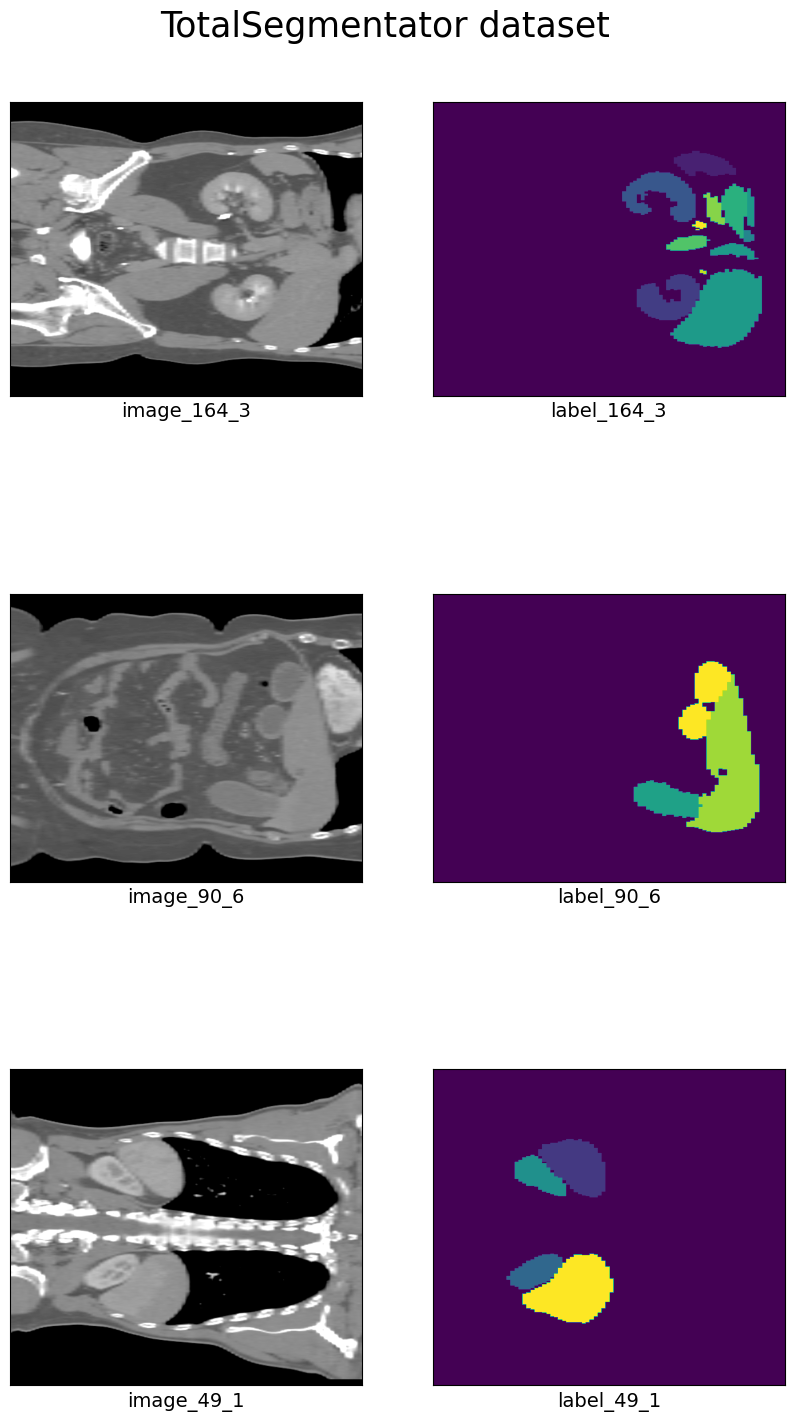

Image shape - (462, 554)
Image shape - (518, 177)
Image shape - (588, 488)


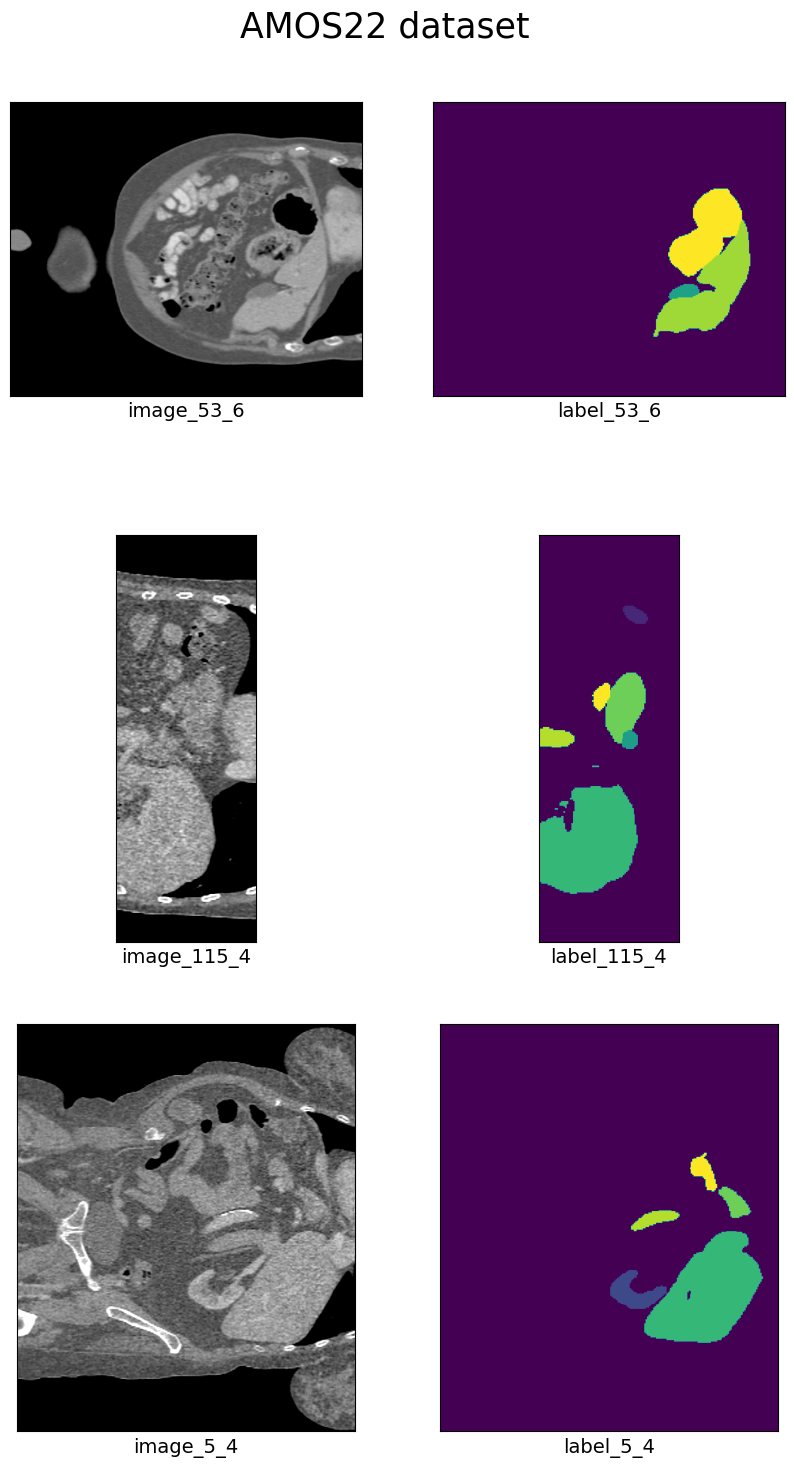

In [ ]:
num_slices = 3
norm = True
assistant.show_slices(num_slices, suffixes, len_ind, ext, folders, norm)

## **Формирование обучающих наборов**

In [ ]:
# split = {"train":0.85, "val":0.1, "test": 0.05}
# assistant.create_split(split, folders, suffixes, json_name)

In [ ]:
num_workers = 12
loaders = assistant.create_loaders(
    batch_size = batch_size,
    json_name = json_name,
    transformations = transformations,
    n_classes = num_classes,
    roi = img_size,
    num_workers = num_workers)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
imgs, target = [], []
for idx, batch_data in enumerate(loaders["test"]):
  if (idx == 1):
    break
  imgs, target = batch_data["image"].to(device), batch_data["label"].to(device)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


## **Обучение SwinUNETR**

In [ ]:
# dice_loss = DiceLoss(include_background = False, to_onehot_y=False, sigmoid=True)
# loss = dice_loss(last_logits, target).item()
# print(loss)
# total_loss = 0
# for i in range(16):
#   total_loss += dice_loss(last_logits[i,:,:,:], target[i,:,:,:]).item()
# print(total_loss/16)

0.580371081829071
0.8156707473099232


In [ ]:
# post_processing = Compose([
#     Activations(sigmoid=True),
#     AsDiscrete(argmax=False, threshold=0.5)
# ])
# dice_acc = DiceMetric(include_background = False, reduction="mean_batch", get_not_nans=True)
# dice_acc.reset()
# dice_acc(y_pred=post_processing(first_logits), y=target)
# acc, not_nans = dice_acc.aggregate()
# print(acc, not_nans)
# acc_mean = acc.mean().cpu().numpy()
# not_nans_all = not_nans.sum().cpu().numpy()
# print(acc_mean.round(4))
# print(not_nans_all)
# print(type(acc_mean))
# print(type(not_nans_all))

tensor([0.6925, 0.6176, 0.4535, 0.8305, 0.7276, 0.8785, 0.6211],
       device='cuda:0') tensor([10.,  9.,  6., 16., 11.,  9.,  7.], device='cuda:0')
0.6887
68.0
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [ ]:
feature_size = 48

swinUNETR = SwinUNETR(
    img_size = img_size,
    in_channels = in_channels,
    out_channels = num_classes,
    feature_size = feature_size,
    drop_rate = 0.0,
    attn_drop_rate = 0.0,
    dropout_path_rate = 0.0,
    use_checkpoint = True,
    spatial_dims = spatial_dims,
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
load_weight_path = os.path.join(base_path, save_weights_path, "train_dice_0.034_epoch_31.pth")

trainer = Trainer(
    model = swinUNETR,
    device = device,
    model_name = model_name,
    path_weights = load_weight_path
)

In [ ]:
start_epoch = 32
max_epochs = 100
val_freq = 5
threshold = 0.5

dice_loss = DiceLoss(include_background = False, to_onehot_y=False, sigmoid=True)
dice_acc = DiceMetric(include_background = False, reduction="mean_batch", get_not_nans=True)

post_processing = Compose([
    Activations(sigmoid=True),
    AsDiscrete(argmax=False, threshold=threshold)
])
adamW = torch.optim.AdamW(trainer.model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(adamW, T_max=max_epochs)

In [ ]:
(val_dice_max,
  train_dice,
  val_dice,
  train_loss,
  val_loss) = trainer.train_model(loaders = loaders,
                                  optimizer = adamW,
                                  loss_func = dice_loss,
                                  acc_func = dice_acc,
                                  scheduler = scheduler,
                                  start_epoch = start_epoch,
                                  max_epochs = max_epochs,
                                  val_freq = val_freq,
                                  post_processing = post_processing,
                                  save_weights_path = os.path.join(base_path, save_weights_path),
                                  name_classes = name_classes)

Epoch: 32
Start time: Wed Apr 17 10:34:07 2024


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 140/140 [01:14<00:00,  1.87it/s]


train_loss: 0.5165, train_dice: 0.7829, time 75.48 s
Saving checkpoint - /content/drive/MyDrive/Work_projects/VisionLabs/data/Weights

Epoch: 33
Start time: Wed Apr 17 10:35:23 2024


100%|██████████| 140/140 [01:14<00:00,  1.88it/s]


train_loss: 0.5115, train_dice: 0.7926, time 74.99 s
Saving checkpoint - /content/drive/MyDrive/Work_projects/VisionLabs/data/Weights

Epoch: 34
Start time: Wed Apr 17 10:36:38 2024


100%|██████████| 140/140 [01:14<00:00,  1.87it/s]


train_loss: 0.5113, train_dice: 0.7908, time 75.42 s
Saving checkpoint - /content/drive/MyDrive/Work_projects/VisionLabs/data/Weights

Epoch: 35
Start time: Wed Apr 17 10:37:54 2024


100%|██████████| 140/140 [01:14<00:00,  1.89it/s]


train_loss: 0.5072, train_dice: 0.7986, time 74.74 s
Saving checkpoint - /content/drive/MyDrive/Work_projects/VisionLabs/data/Weights
Validation


100%|██████████| 17/17 [00:31<00:00,  1.83s/it]


val_dice_Spleen: 0.8359
val_dice_Right kidney: 0.8254
val_dice_Left kidney: 0.7531
val_dice_Liver: 0.9068
val_dice_Stomach: 0.7481
val_dice_Aorta: 0.7527
val_dice_Pancreas: 0.5336
val_loss: 0.5081, val_dice_mean: 0.7651, time 31.56 s
New best Dice coefficient (0.000000 --> 0.765106). 
Saving checkpoint - /content/drive/MyDrive/Work_projects/VisionLabs/data/Weights

Epoch: 36
Start time: Wed Apr 17 10:39:41 2024


100%|██████████| 140/140 [01:14<00:00,  1.88it/s]


train_loss: 0.5083, train_dice: 0.7960, time 74.87 s
Saving checkpoint - /content/drive/MyDrive/Work_projects/VisionLabs/data/Weights

Epoch: 37
Start time: Wed Apr 17 10:40:56 2024


100%|██████████| 140/140 [01:14<00:00,  1.88it/s]


train_loss: 0.5061, train_dice: 0.8007, time 74.92 s
Saving checkpoint - /content/drive/MyDrive/Work_projects/VisionLabs/data/Weights

Epoch: 38
Start time: Wed Apr 17 10:42:11 2024


100%|██████████| 140/140 [01:14<00:00,  1.88it/s]


train_loss: 0.5022, train_dice: 0.8048, time 74.97 s
Saving checkpoint - /content/drive/MyDrive/Work_projects/VisionLabs/data/Weights

Epoch: 39
Start time: Wed Apr 17 10:43:26 2024


100%|██████████| 140/140 [01:14<00:00,  1.89it/s]


train_loss: 0.5022, train_dice: 0.8060, time 74.59 s
Saving checkpoint - /content/drive/MyDrive/Work_projects/VisionLabs/data/Weights

Epoch: 40
Start time: Wed Apr 17 10:44:41 2024


100%|██████████| 140/140 [01:14<00:00,  1.87it/s]


train_loss: 0.5050, train_dice: 0.8012, time 75.42 s
Saving checkpoint - /content/drive/MyDrive/Work_projects/VisionLabs/data/Weights
Validation


100%|██████████| 17/17 [00:06<00:00,  2.66it/s]

val_dice_Spleen: 0.8278
val_dice_Right kidney: 0.7989
val_dice_Left kidney: 0.7378
val_dice_Liver: 0.9050
val_dice_Stomach: 0.7283
val_dice_Aorta: 0.7625
val_dice_Pancreas: 0.5367
val_loss: 0.5115, val_dice_mean: 0.7567, time 6.87 s

Epoch: 41
Start time: Wed Apr 17 10:46:04 2024



100%|██████████| 140/140 [01:14<00:00,  1.88it/s]


train_loss: 0.5015, train_dice: 0.8082, time 75.17 s
Saving checkpoint - /content/drive/MyDrive/Work_projects/VisionLabs/data/Weights

Epoch: 42
Start time: Wed Apr 17 10:47:19 2024


100%|██████████| 140/140 [01:14<00:00,  1.89it/s]


train_loss: 0.4979, train_dice: 0.8144, time 74.73 s
Saving checkpoint - /content/drive/MyDrive/Work_projects/VisionLabs/data/Weights

Epoch: 43
Start time: Wed Apr 17 10:48:34 2024


100%|██████████| 140/140 [01:14<00:00,  1.88it/s]


train_loss: 0.5064, train_dice: 0.7989, time 75.07 s
Saving checkpoint - /content/drive/MyDrive/Work_projects/VisionLabs/data/Weights

Epoch: 44
Start time: Wed Apr 17 10:49:50 2024


100%|██████████| 140/140 [01:14<00:00,  1.88it/s]


train_loss: 0.4982, train_dice: 0.8135, time 74.93 s
Saving checkpoint - /content/drive/MyDrive/Work_projects/VisionLabs/data/Weights

Epoch: 45
Start time: Wed Apr 17 10:51:05 2024


100%|██████████| 140/140 [01:14<00:00,  1.88it/s]


train_loss: 0.4981, train_dice: 0.8137, time 75.10 s
Saving checkpoint - /content/drive/MyDrive/Work_projects/VisionLabs/data/Weights
Validation


100%|██████████| 17/17 [00:06<00:00,  2.61it/s]


val_dice_Spleen: 0.8384
val_dice_Right kidney: 0.8095
val_dice_Left kidney: 0.7445
val_dice_Liver: 0.9127
val_dice_Stomach: 0.7560
val_dice_Aorta: 0.7807
val_dice_Pancreas: 0.5406
val_loss: 0.4977, val_dice_mean: 0.7689, time 7.06 s
New best Dice coefficient (0.765106 --> 0.768911). 
Saving checkpoint - /content/drive/MyDrive/Work_projects/VisionLabs/data/Weights

Epoch: 46
Start time: Wed Apr 17 10:52:28 2024


100%|██████████| 140/140 [01:14<00:00,  1.87it/s]


train_loss: 0.4929, train_dice: 0.8226, time 75.40 s
Saving checkpoint - /content/drive/MyDrive/Work_projects/VisionLabs/data/Weights

Epoch: 47
Start time: Wed Apr 17 10:53:44 2024


100%|██████████| 140/140 [01:14<00:00,  1.88it/s]


train_loss: 0.4894, train_dice: 0.8294, time 75.08 s
Saving checkpoint - /content/drive/MyDrive/Work_projects/VisionLabs/data/Weights

Epoch: 48
Start time: Wed Apr 17 10:54:59 2024


100%|██████████| 140/140 [01:14<00:00,  1.87it/s]


train_loss: 0.4914, train_dice: 0.8242, time 75.49 s
Saving checkpoint - /content/drive/MyDrive/Work_projects/VisionLabs/data/Weights

Epoch: 49
Start time: Wed Apr 17 10:56:15 2024


100%|██████████| 140/140 [01:14<00:00,  1.88it/s]


train_loss: 0.4927, train_dice: 0.8236, time 74.83 s
Saving checkpoint - /content/drive/MyDrive/Work_projects/VisionLabs/data/Weights

Epoch: 50
Start time: Wed Apr 17 10:57:30 2024


100%|██████████| 140/140 [01:14<00:00,  1.88it/s]


train_loss: 0.4931, train_dice: 0.8233, time 75.14 s
Saving checkpoint - /content/drive/MyDrive/Work_projects/VisionLabs/data/Weights
Validation


100%|██████████| 17/17 [00:06<00:00,  2.65it/s]


val_dice_Spleen: 0.8442
val_dice_Right kidney: 0.8252
val_dice_Left kidney: 0.7660
val_dice_Liver: 0.9098
val_dice_Stomach: 0.7592
val_dice_Aorta: 0.7998
val_dice_Pancreas: 0.5605
val_loss: 0.4940, val_dice_mean: 0.7807, time 6.96 s
New best Dice coefficient (0.768911 --> 0.780662). 
Saving checkpoint - /content/drive/MyDrive/Work_projects/VisionLabs/data/Weights

Epoch: 51
Start time: Wed Apr 17 10:58:53 2024


100%|██████████| 140/140 [01:14<00:00,  1.87it/s]


train_loss: 0.4890, train_dice: 0.8300, time 75.33 s
Saving checkpoint - /content/drive/MyDrive/Work_projects/VisionLabs/data/Weights

Epoch: 52
Start time: Wed Apr 17 11:00:08 2024


100%|██████████| 140/140 [01:14<00:00,  1.88it/s]


train_loss: 0.4886, train_dice: 0.8291, time 74.95 s
Saving checkpoint - /content/drive/MyDrive/Work_projects/VisionLabs/data/Weights

Epoch: 53
Start time: Wed Apr 17 11:01:24 2024


100%|██████████| 140/140 [01:14<00:00,  1.88it/s]


train_loss: 0.4898, train_dice: 0.8294, time 75.09 s
Saving checkpoint - /content/drive/MyDrive/Work_projects/VisionLabs/data/Weights

Epoch: 54
Start time: Wed Apr 17 11:02:39 2024


100%|██████████| 140/140 [01:14<00:00,  1.87it/s]


train_loss: 0.4894, train_dice: 0.8304, time 75.22 s
Saving checkpoint - /content/drive/MyDrive/Work_projects/VisionLabs/data/Weights

Epoch: 55
Start time: Wed Apr 17 11:03:55 2024


100%|██████████| 140/140 [01:14<00:00,  1.89it/s]


train_loss: 0.4833, train_dice: 0.8388, time 74.58 s
Saving checkpoint - /content/drive/MyDrive/Work_projects/VisionLabs/data/Weights
Validation


100%|██████████| 17/17 [00:06<00:00,  2.67it/s]

val_dice_Spleen: 0.8413
val_dice_Right kidney: 0.8189
val_dice_Left kidney: 0.7727
val_dice_Liver: 0.9127
val_dice_Stomach: 0.7708
val_dice_Aorta: 0.7901
val_dice_Pancreas: 0.5411
val_loss: 0.4960, val_dice_mean: 0.7782, time 6.87 s

Epoch: 56
Start time: Wed Apr 17 11:05:16 2024



100%|██████████| 140/140 [01:14<00:00,  1.87it/s]


train_loss: 0.4799, train_dice: 0.8423, time 75.21 s
Saving checkpoint - /content/drive/MyDrive/Work_projects/VisionLabs/data/Weights

Epoch: 57
Start time: Wed Apr 17 11:06:32 2024


100%|██████████| 140/140 [01:13<00:00,  1.89it/s]


train_loss: 0.4799, train_dice: 0.8453, time 74.50 s
Saving checkpoint - /content/drive/MyDrive/Work_projects/VisionLabs/data/Weights

Epoch: 58
Start time: Wed Apr 17 11:07:47 2024


100%|██████████| 140/140 [01:14<00:00,  1.88it/s]


train_loss: 0.4839, train_dice: 0.8374, time 75.11 s
Saving checkpoint - /content/drive/MyDrive/Work_projects/VisionLabs/data/Weights

Epoch: 59
Start time: Wed Apr 17 11:09:02 2024


100%|██████████| 140/140 [01:14<00:00,  1.88it/s]


train_loss: 0.4851, train_dice: 0.8362, time 75.18 s
Saving checkpoint - /content/drive/MyDrive/Work_projects/VisionLabs/data/Weights

Epoch: 60
Start time: Wed Apr 17 11:10:18 2024


100%|██████████| 140/140 [01:14<00:00,  1.89it/s]


train_loss: 0.4853, train_dice: 0.8378, time 74.72 s
Saving checkpoint - /content/drive/MyDrive/Work_projects/VisionLabs/data/Weights
Validation


100%|██████████| 17/17 [00:06<00:00,  2.64it/s]


val_dice_Spleen: 0.8580
val_dice_Right kidney: 0.8429
val_dice_Left kidney: 0.7805
val_dice_Liver: 0.9244
val_dice_Stomach: 0.7799
val_dice_Aorta: 0.7942
val_dice_Pancreas: 0.5620
val_loss: 0.4939, val_dice_mean: 0.7917, time 6.97 s
New best Dice coefficient (0.780662 --> 0.791707). 
Saving checkpoint - /content/drive/MyDrive/Work_projects/VisionLabs/data/Weights

Epoch: 61
Start time: Wed Apr 17 11:11:40 2024


100%|██████████| 140/140 [01:14<00:00,  1.88it/s]


train_loss: 0.4814, train_dice: 0.8440, time 74.83 s
Saving checkpoint - /content/drive/MyDrive/Work_projects/VisionLabs/data/Weights

Epoch: 62
Start time: Wed Apr 17 11:12:55 2024


100%|██████████| 140/140 [01:14<00:00,  1.88it/s]


train_loss: 0.4842, train_dice: 0.8387, time 75.16 s
Saving checkpoint - /content/drive/MyDrive/Work_projects/VisionLabs/data/Weights

Epoch: 63
Start time: Wed Apr 17 11:14:11 2024


100%|██████████| 140/140 [01:14<00:00,  1.89it/s]


train_loss: 0.4784, train_dice: 0.8469, time 74.55 s
Saving checkpoint - /content/drive/MyDrive/Work_projects/VisionLabs/data/Weights

Epoch: 64
Start time: Wed Apr 17 11:15:26 2024


100%|██████████| 140/140 [01:14<00:00,  1.89it/s]


train_loss: 0.4792, train_dice: 0.8477, time 74.74 s
Saving checkpoint - /content/drive/MyDrive/Work_projects/VisionLabs/data/Weights

Epoch: 65
Start time: Wed Apr 17 11:16:41 2024


100%|██████████| 140/140 [01:14<00:00,  1.88it/s]


train_loss: 0.4780, train_dice: 0.8507, time 75.04 s
Saving checkpoint - /content/drive/MyDrive/Work_projects/VisionLabs/data/Weights
Validation


100%|██████████| 17/17 [00:06<00:00,  2.66it/s]


val_dice_Spleen: 0.8404
val_dice_Right kidney: 0.8360
val_dice_Left kidney: 0.7873
val_dice_Liver: 0.9177
val_dice_Stomach: 0.7866
val_dice_Aorta: 0.7986
val_dice_Pancreas: 0.5827
val_loss: 0.4869, val_dice_mean: 0.7928, time 6.88 s
New best Dice coefficient (0.791707 --> 0.792756). 
Saving checkpoint - /content/drive/MyDrive/Work_projects/VisionLabs/data/Weights

Epoch: 66
Start time: Wed Apr 17 11:18:03 2024


100%|██████████| 140/140 [01:14<00:00,  1.88it/s]


train_loss: 0.4772, train_dice: 0.8506, time 74.99 s
Saving checkpoint - /content/drive/MyDrive/Work_projects/VisionLabs/data/Weights

Epoch: 67
Start time: Wed Apr 17 11:19:19 2024


100%|██████████| 140/140 [01:14<00:00,  1.88it/s]


train_loss: 0.4129, train_dice: 0.7477, time 75.17 s
Saving checkpoint - /content/drive/MyDrive/Work_projects/VisionLabs/data/Weights

Epoch: 68
Start time: Wed Apr 17 11:20:34 2024


100%|██████████| 140/140 [01:14<00:00,  1.88it/s]


train_loss: 0.3422, train_dice: 0.5677, time 75.08 s
Saving checkpoint - /content/drive/MyDrive/Work_projects/VisionLabs/data/Weights

Epoch: 69
Start time: Wed Apr 17 11:21:50 2024


100%|██████████| 140/140 [01:14<00:00,  1.89it/s]


train_loss: 0.3112, train_dice: 0.6035, time 74.76 s
Saving checkpoint - /content/drive/MyDrive/Work_projects/VisionLabs/data/Weights

Epoch: 70
Start time: Wed Apr 17 11:23:05 2024


100%|██████████| 140/140 [01:14<00:00,  1.88it/s]


train_loss: 0.2885, train_dice: 0.6590, time 74.85 s
Saving checkpoint - /content/drive/MyDrive/Work_projects/VisionLabs/data/Weights
Validation


100%|██████████| 17/17 [00:06<00:00,  2.65it/s]

val_dice_Spleen: 0.8017
val_dice_Right kidney: 0.5904
val_dice_Left kidney: 0.5832
val_dice_Liver: 0.8855
val_dice_Stomach: 0.5800
val_dice_Aorta: 0.4439
val_dice_Pancreas: 0.4161
val_loss: 0.3049, val_dice_mean: 0.6144, time 6.92 s

Epoch: 71
Start time: Wed Apr 17 11:24:27 2024



100%|██████████| 140/140 [01:14<00:00,  1.87it/s]


train_loss: 0.2785, train_dice: 0.6645, time 75.39 s
Saving checkpoint - /content/drive/MyDrive/Work_projects/VisionLabs/data/Weights

Epoch: 72
Start time: Wed Apr 17 11:25:42 2024


100%|██████████| 140/140 [01:14<00:00,  1.87it/s]


train_loss: 0.2639, train_dice: 0.6906, time 75.33 s
Saving checkpoint - /content/drive/MyDrive/Work_projects/VisionLabs/data/Weights

Epoch: 73
Start time: Wed Apr 17 11:26:58 2024


100%|██████████| 140/140 [01:14<00:00,  1.88it/s]


train_loss: 0.2464, train_dice: 0.7247, time 74.86 s
Saving checkpoint - /content/drive/MyDrive/Work_projects/VisionLabs/data/Weights

Epoch: 74
Start time: Wed Apr 17 11:28:13 2024


100%|██████████| 140/140 [01:14<00:00,  1.88it/s]


train_loss: 0.2496, train_dice: 0.7112, time 74.99 s
Saving checkpoint - /content/drive/MyDrive/Work_projects/VisionLabs/data/Weights

Epoch: 75
Start time: Wed Apr 17 11:29:29 2024


100%|██████████| 140/140 [01:14<00:00,  1.87it/s]


train_loss: 0.2461, train_dice: 0.7139, time 75.51 s
Saving checkpoint - /content/drive/MyDrive/Work_projects/VisionLabs/data/Weights
Validation


100%|██████████| 17/17 [00:06<00:00,  2.68it/s]

val_dice_Spleen: 0.8263
val_dice_Right kidney: 0.7923
val_dice_Left kidney: 0.6805
val_dice_Liver: 0.9030
val_dice_Stomach: 0.6660
val_dice_Aorta: 0.5585
val_dice_Pancreas: 0.4184
val_loss: 0.2649, val_dice_mean: 0.6921, time 6.83 s

Epoch: 76
Start time: Wed Apr 17 11:30:51 2024



100%|██████████| 140/140 [01:14<00:00,  1.89it/s]


train_loss: 0.2517, train_dice: 0.7106, time 74.64 s
Saving checkpoint - /content/drive/MyDrive/Work_projects/VisionLabs/data/Weights

Epoch: 77
Start time: Wed Apr 17 11:32:06 2024


100%|██████████| 140/140 [01:13<00:00,  1.90it/s]


train_loss: 0.2424, train_dice: 0.7282, time 74.37 s
Saving checkpoint - /content/drive/MyDrive/Work_projects/VisionLabs/data/Weights

Epoch: 78
Start time: Wed Apr 17 11:33:21 2024


100%|██████████| 140/140 [01:14<00:00,  1.88it/s]


train_loss: 0.2474, train_dice: 0.7051, time 75.16 s
Saving checkpoint - /content/drive/MyDrive/Work_projects/VisionLabs/data/Weights

Epoch: 79
Start time: Wed Apr 17 11:34:36 2024


100%|██████████| 140/140 [01:14<00:00,  1.88it/s]


train_loss: 0.2343, train_dice: 0.7324, time 74.90 s
Saving checkpoint - /content/drive/MyDrive/Work_projects/VisionLabs/data/Weights

Epoch: 80
Start time: Wed Apr 17 11:35:52 2024


100%|██████████| 140/140 [01:14<00:00,  1.89it/s]


train_loss: 0.2230, train_dice: 0.7442, time 74.63 s
Saving checkpoint - /content/drive/MyDrive/Work_projects/VisionLabs/data/Weights
Validation


100%|██████████| 17/17 [00:06<00:00,  2.67it/s]

val_dice_Spleen: 0.8290
val_dice_Right kidney: 0.8066
val_dice_Left kidney: 0.7312
val_dice_Liver: 0.9005
val_dice_Stomach: 0.7041
val_dice_Aorta: 0.6900
val_dice_Pancreas: 0.3828
val_loss: 0.2557, val_dice_mean: 0.7206, time 6.86 s

Epoch: 81
Start time: Wed Apr 17 11:37:13 2024



 29%|██▊       | 40/140 [00:23<00:57,  1.73it/s]
Process Process-755:
Process Process-754:
Process Process-756:
Process Process-753:
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b4c85b69240>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1443, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.10/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.10/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 931, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.10/selectors.py", line 416, in select
    fd_event_list = self._selector.

KeyboardInterrupt: 

## **Оценка качества работы на тестовой выборке**

In [ ]:
feature_size = 48

swinUNETR = SwinUNETR(
    img_size = img_size,
    in_channels = in_channels,
    out_channels = num_classes,
    feature_size = feature_size,
    drop_rate = 0.0,
    attn_drop_rate = 0.0,
    dropout_path_rate = 0.0,
    use_checkpoint = True,
    spatial_dims = spatial_dims,
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
best_weights = os.path.join(base_path, save_weights_path, "best_val_dice_0.7954000234603882_epoch_90.pth")

trainer = Trainer(
    model = swinUNETR,
    device = device,
    model_name = model_name,
    path_weights = best_weights
)

Validation


100%|██████████| 9/9 [00:03<00:00,  2.74it/s]


Dice accuracy:
Background - 0.8085
Spleen - 0.8245
Right kidney - 0.7663
Left kidney - 0.7776
Liver - 0.9225
Stomach - 0.7884
Aorta - 0.8381
Pancreas - 0.6226
Mean dice -  - 0.7936


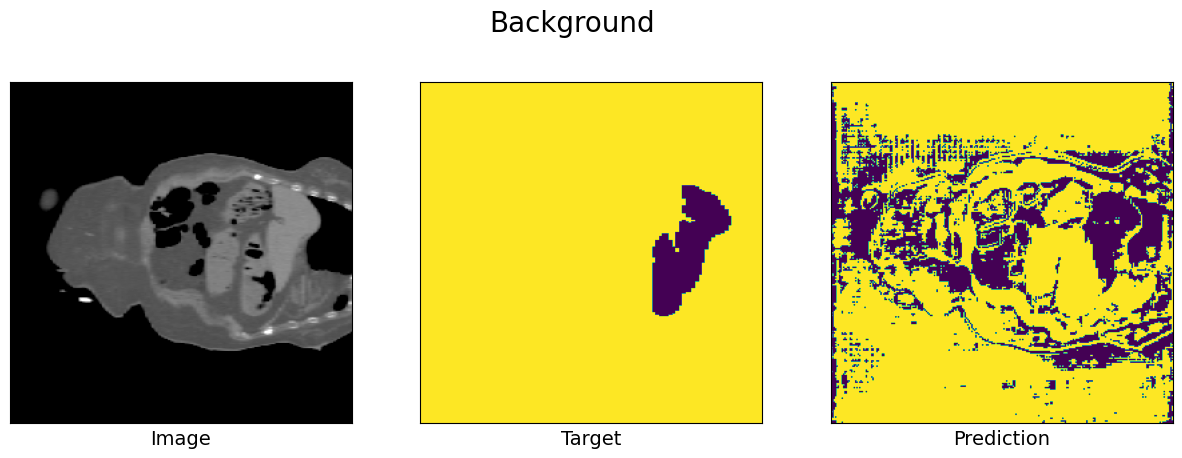

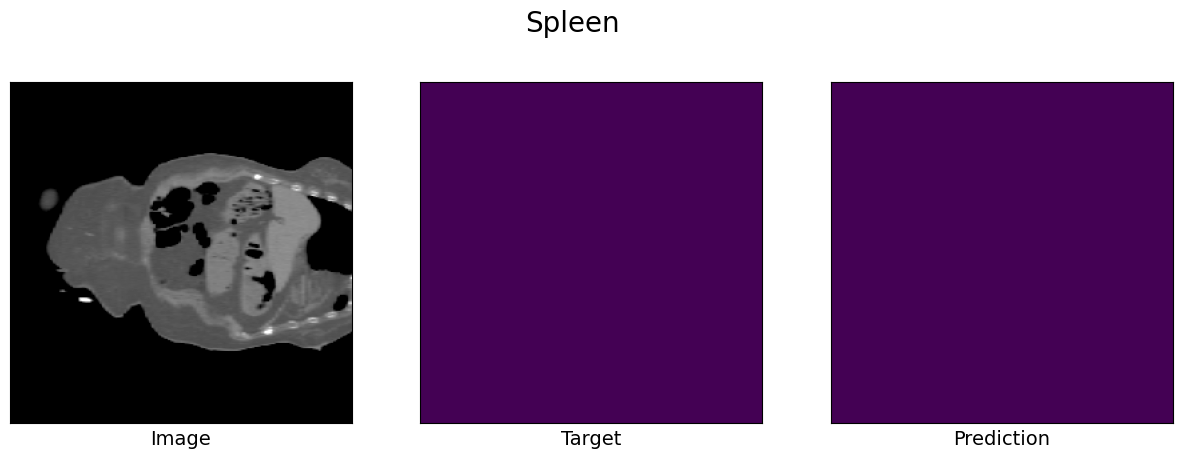

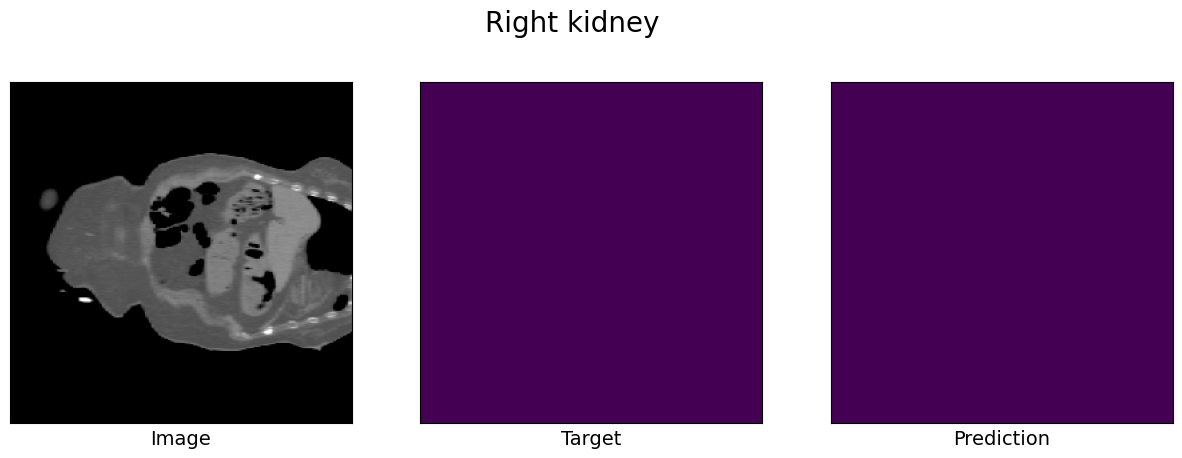

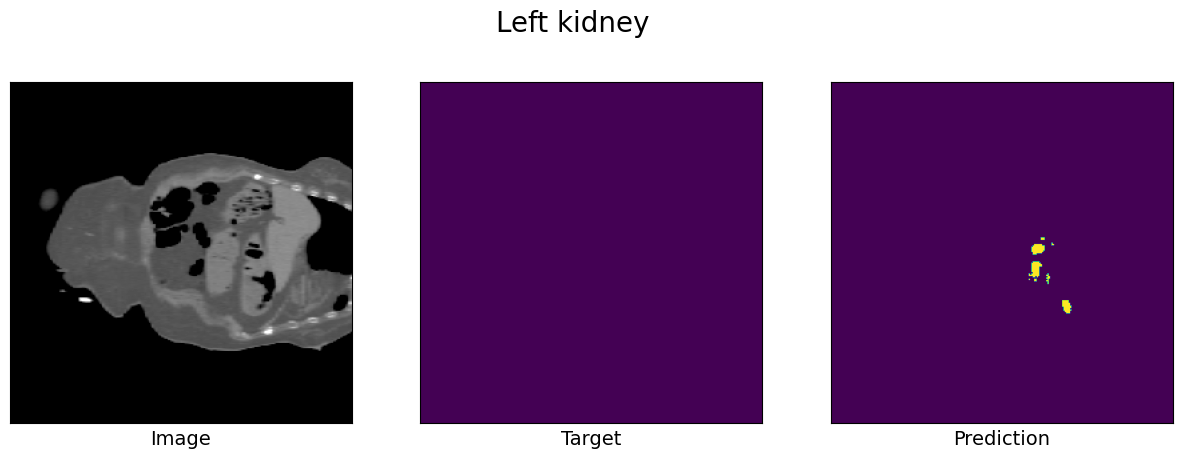

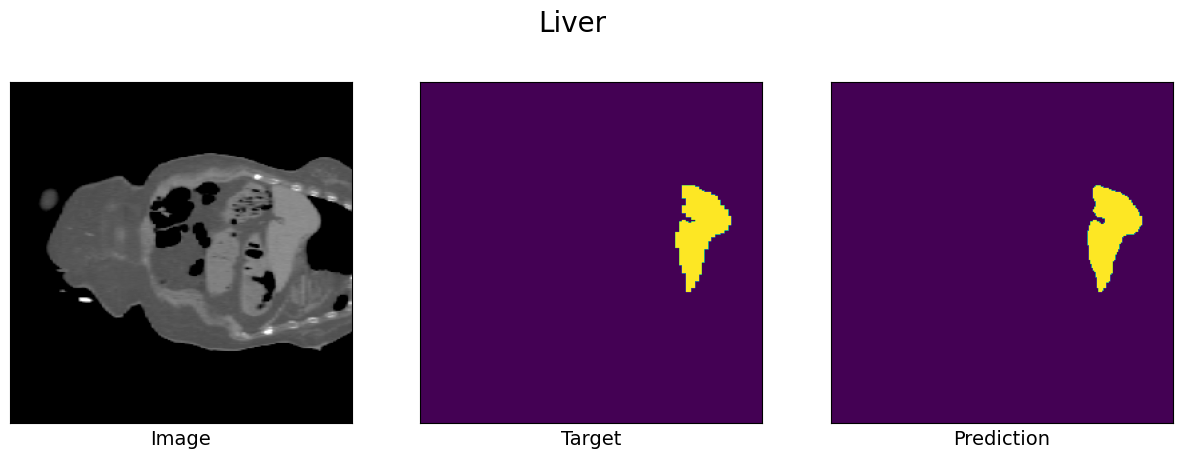

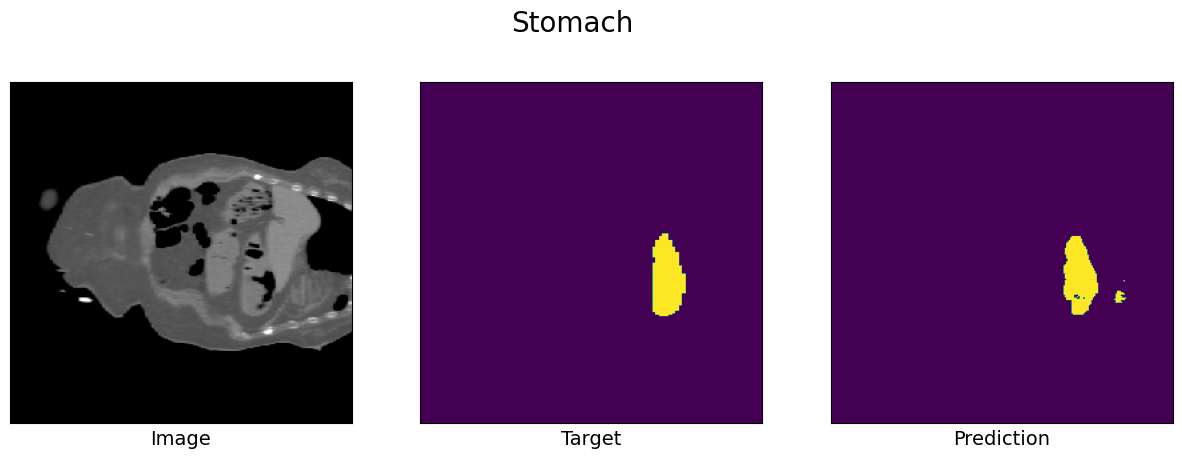

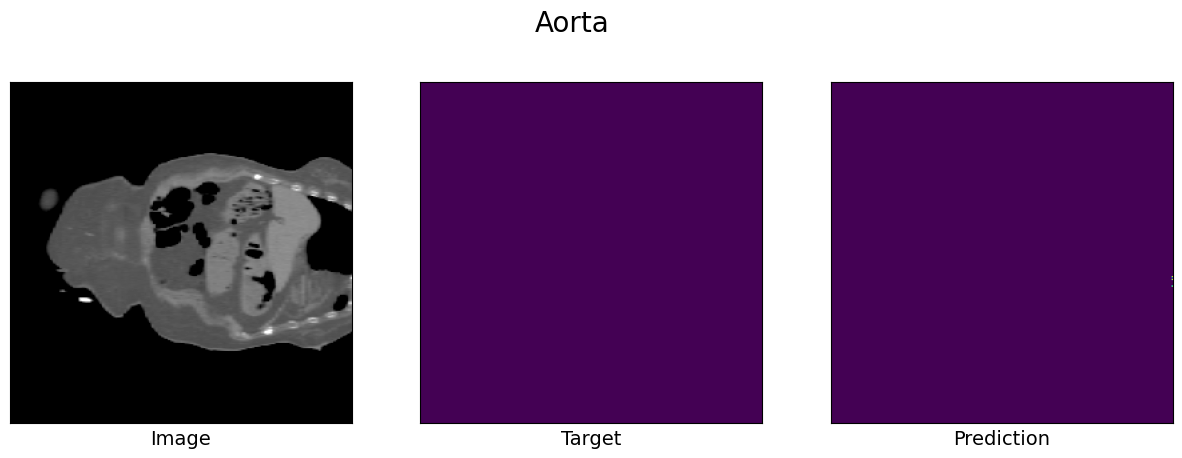

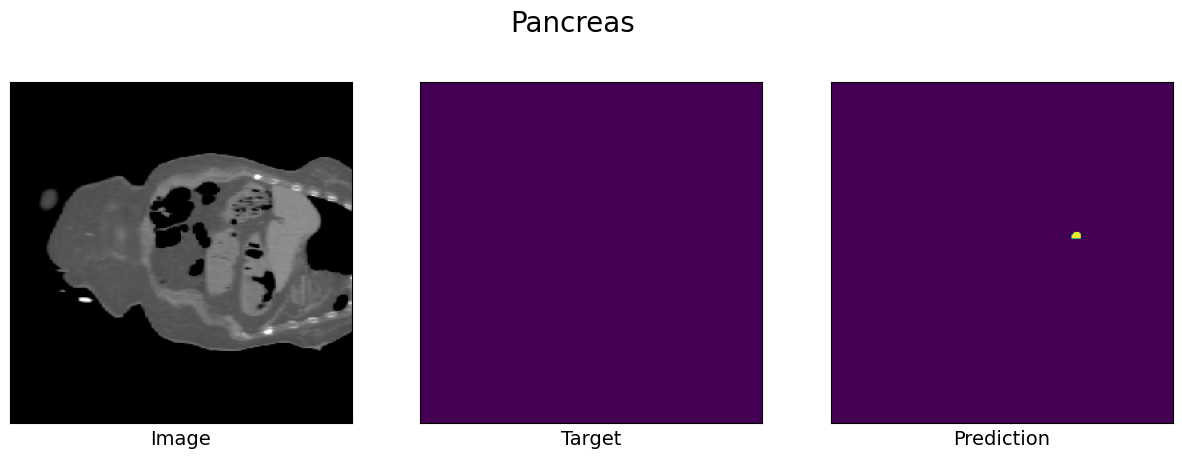

In [ ]:
threshold = 0.5
dice_acc = DiceMetric(reduction="mean_batch", get_not_nans=True)
dice_loss = DiceLoss(include_background = False, to_onehot_y=False, sigmoid=True)
post_processing = Compose([
    Activations(sigmoid=True),
    AsDiscrete(argmax=False, threshold=threshold)
])

show_classes = ["Background", "Spleen", "Right kidney", "Left kidney", "Liver", "Stomach", "Aorta", "Pancreas"]

test_accuracy = trainer.quality_control(
    loader = loaders["test"],
    acc_func = dice_acc,
    loss_func = dice_loss,
    post_processing = post_processing,
    show_classes = show_classes,
    name_classes = name_classes
)

## **Обучение SwinUNETR (взвешенные веса функции ошибки)**

In [ ]:
start_epoch = 66
max_epochs = 100
val_freq = 5
threshold = 0.5
loss_weights = test_accuracy**-5

dice_loss = DiceLoss(include_background = False, to_onehot_y=False, sigmoid=True, weight = loss_weights)
dice_acc = DiceMetric(include_background = False, reduction="mean_batch", get_not_nans=True)

post_processing = Compose([
    Activations(sigmoid=True),
    AsDiscrete(argmax=False, threshold=threshold)
])
adamW = torch.optim.AdamW(trainer.model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(adamW, T_max=max_epochs)

In [ ]:
(val_dice_max,
  train_dice,
  val_dice,
  train_loss,
  val_loss) = trainer.train_model(loaders = loaders,
                                  optimizer = adamW,
                                  loss_func = dice_loss,
                                  acc_func = dice_acc,
                                  scheduler = scheduler,
                                  start_epoch = start_epoch,
                                  max_epochs = max_epochs,
                                  val_freq = val_freq,
                                  post_processing = post_processing,
                                  save_weights_path = os.path.join(base_path, save_weights_path),
                                  name_classes = name_classes)

Epoch: 66
Start time: Wed Apr 17 13:55:31 2024


100%|██████████| 140/140 [01:12<00:00,  1.93it/s]


train_loss: 2.2071, train_dice: 0.8550, time 72.98 s
Saving checkpoint - /content/drive/MyDrive/Work_projects/VisionLabs/data/Weights

Epoch: 67
Start time: Wed Apr 17 13:56:44 2024


100%|██████████| 140/140 [01:11<00:00,  1.95it/s]


train_loss: 2.2125, train_dice: 0.8546, time 72.45 s
Saving checkpoint - /content/drive/MyDrive/Work_projects/VisionLabs/data/Weights

Epoch: 68
Start time: Wed Apr 17 13:57:57 2024


100%|██████████| 140/140 [01:12<00:00,  1.94it/s]


train_loss: 2.2156, train_dice: 0.8537, time 72.64 s
Saving checkpoint - /content/drive/MyDrive/Work_projects/VisionLabs/data/Weights

Epoch: 69
Start time: Wed Apr 17 13:59:10 2024


100%|██████████| 140/140 [01:12<00:00,  1.94it/s]


train_loss: 2.2130, train_dice: 0.8555, time 72.72 s
Saving checkpoint - /content/drive/MyDrive/Work_projects/VisionLabs/data/Weights

Epoch: 70
Start time: Wed Apr 17 14:00:23 2024


100%|██████████| 140/140 [01:11<00:00,  1.95it/s]


train_loss: 2.2097, train_dice: 0.8541, time 72.34 s
Saving checkpoint - /content/drive/MyDrive/Work_projects/VisionLabs/data/Weights
Validation


100%|██████████| 17/17 [00:06<00:00,  2.80it/s]


val_dice_Spleen: 0.8523
val_dice_Right kidney: 0.8358
val_dice_Left kidney: 0.7755
val_dice_Liver: 0.9225
val_dice_Stomach: 0.7809
val_dice_Aorta: 0.8009
val_dice_Pancreas: 0.5818
val_loss: 2.2687, val_dice_mean: 0.7928, time 6.57 s
New best Dice coefficient (0.000000 --> 0.792826). 
Saving checkpoint - /content/drive/MyDrive/Work_projects/VisionLabs/data/Weights

Epoch: 71
Start time: Wed Apr 17 14:01:42 2024


100%|██████████| 140/140 [01:11<00:00,  1.96it/s]


train_loss: 2.2122, train_dice: 0.8542, time 72.05 s
Saving checkpoint - /content/drive/MyDrive/Work_projects/VisionLabs/data/Weights

Epoch: 72
Start time: Wed Apr 17 14:02:55 2024


100%|██████████| 140/140 [01:12<00:00,  1.94it/s]


train_loss: 2.2153, train_dice: 0.8538, time 72.55 s
Saving checkpoint - /content/drive/MyDrive/Work_projects/VisionLabs/data/Weights

Epoch: 73
Start time: Wed Apr 17 14:04:07 2024


100%|██████████| 140/140 [01:11<00:00,  1.95it/s]


train_loss: 2.2187, train_dice: 0.8535, time 72.50 s
Saving checkpoint - /content/drive/MyDrive/Work_projects/VisionLabs/data/Weights

Epoch: 74
Start time: Wed Apr 17 14:05:20 2024


100%|██████████| 140/140 [01:12<00:00,  1.94it/s]


train_loss: 2.2122, train_dice: 0.8531, time 72.57 s
Saving checkpoint - /content/drive/MyDrive/Work_projects/VisionLabs/data/Weights

Epoch: 75
Start time: Wed Apr 17 14:06:33 2024


100%|██████████| 140/140 [01:11<00:00,  1.96it/s]


train_loss: 2.2094, train_dice: 0.8536, time 71.85 s
Saving checkpoint - /content/drive/MyDrive/Work_projects/VisionLabs/data/Weights
Validation


100%|██████████| 17/17 [00:05<00:00,  2.83it/s]

val_dice_Spleen: 0.8520
val_dice_Right kidney: 0.8328
val_dice_Left kidney: 0.7709
val_dice_Liver: 0.9207
val_dice_Stomach: 0.7848
val_dice_Aorta: 0.7965
val_dice_Pancreas: 0.5803
val_loss: 2.2752, val_dice_mean: 0.7911, time 6.51 s

Epoch: 76
Start time: Wed Apr 17 14:07:52 2024



100%|██████████| 140/140 [01:11<00:00,  1.96it/s]


train_loss: 2.2174, train_dice: 0.8529, time 71.77 s
Saving checkpoint - /content/drive/MyDrive/Work_projects/VisionLabs/data/Weights

Epoch: 77
Start time: Wed Apr 17 14:09:04 2024


100%|██████████| 140/140 [01:12<00:00,  1.94it/s]


train_loss: 2.2135, train_dice: 0.8533, time 72.60 s
Saving checkpoint - /content/drive/MyDrive/Work_projects/VisionLabs/data/Weights

Epoch: 78
Start time: Wed Apr 17 14:10:17 2024


100%|██████████| 140/140 [01:11<00:00,  1.96it/s]


train_loss: 2.2119, train_dice: 0.8544, time 71.85 s
Saving checkpoint - /content/drive/MyDrive/Work_projects/VisionLabs/data/Weights

Epoch: 79
Start time: Wed Apr 17 14:11:29 2024


100%|██████████| 140/140 [01:11<00:00,  1.95it/s]


train_loss: 2.2128, train_dice: 0.8544, time 72.39 s
Saving checkpoint - /content/drive/MyDrive/Work_projects/VisionLabs/data/Weights

Epoch: 80
Start time: Wed Apr 17 14:12:41 2024


100%|██████████| 140/140 [01:11<00:00,  1.95it/s]


train_loss: 2.2179, train_dice: 0.8542, time 72.45 s
Saving checkpoint - /content/drive/MyDrive/Work_projects/VisionLabs/data/Weights
Validation


100%|██████████| 17/17 [00:05<00:00,  2.85it/s]


val_dice_Spleen: 0.8462
val_dice_Right kidney: 0.8314
val_dice_Left kidney: 0.7743
val_dice_Liver: 0.9206
val_dice_Stomach: 0.7886
val_dice_Aorta: 0.7948
val_dice_Pancreas: 0.5947
val_loss: 2.2639, val_dice_mean: 0.7929, time 6.44 s
New best Dice coefficient (0.792826 --> 0.792939). 
Saving checkpoint - /content/drive/MyDrive/Work_projects/VisionLabs/data/Weights

Epoch: 81
Start time: Wed Apr 17 14:14:01 2024


100%|██████████| 140/140 [01:11<00:00,  1.95it/s]


train_loss: 2.2135, train_dice: 0.8547, time 72.19 s
Saving checkpoint - /content/drive/MyDrive/Work_projects/VisionLabs/data/Weights

Epoch: 82
Start time: Wed Apr 17 14:15:13 2024


100%|██████████| 140/140 [01:12<00:00,  1.93it/s]


train_loss: 2.2134, train_dice: 0.8535, time 73.03 s
Saving checkpoint - /content/drive/MyDrive/Work_projects/VisionLabs/data/Weights

Epoch: 83
Start time: Wed Apr 17 14:16:27 2024


100%|██████████| 140/140 [01:12<00:00,  1.94it/s]


train_loss: 2.2171, train_dice: 0.8547, time 72.66 s
Saving checkpoint - /content/drive/MyDrive/Work_projects/VisionLabs/data/Weights

Epoch: 84
Start time: Wed Apr 17 14:17:40 2024


100%|██████████| 140/140 [01:12<00:00,  1.93it/s]


train_loss: 2.2140, train_dice: 0.8550, time 72.94 s
Saving checkpoint - /content/drive/MyDrive/Work_projects/VisionLabs/data/Weights

Epoch: 85
Start time: Wed Apr 17 14:18:53 2024


100%|██████████| 140/140 [01:11<00:00,  1.95it/s]


train_loss: 2.2152, train_dice: 0.8533, time 72.31 s
Saving checkpoint - /content/drive/MyDrive/Work_projects/VisionLabs/data/Weights
Validation


100%|██████████| 17/17 [00:06<00:00,  2.82it/s]

val_dice_Spleen: 0.8387
val_dice_Right kidney: 0.8265
val_dice_Left kidney: 0.7643
val_dice_Liver: 0.9132
val_dice_Stomach: 0.7829
val_dice_Aorta: 0.8040
val_dice_Pancreas: 0.5869
val_loss: 2.2749, val_dice_mean: 0.7881, time 6.49 s

Epoch: 86
Start time: Wed Apr 17 14:20:12 2024



100%|██████████| 140/140 [01:11<00:00,  1.96it/s]


train_loss: 2.2101, train_dice: 0.8545, time 72.08 s
Saving checkpoint - /content/drive/MyDrive/Work_projects/VisionLabs/data/Weights

Epoch: 87
Start time: Wed Apr 17 14:21:24 2024


100%|██████████| 140/140 [01:12<00:00,  1.94it/s]


train_loss: 2.2103, train_dice: 0.8538, time 72.76 s
Saving checkpoint - /content/drive/MyDrive/Work_projects/VisionLabs/data/Weights

Epoch: 88
Start time: Wed Apr 17 14:22:37 2024


100%|██████████| 140/140 [01:12<00:00,  1.94it/s]


train_loss: 2.2094, train_dice: 0.8544, time 72.80 s
Saving checkpoint - /content/drive/MyDrive/Work_projects/VisionLabs/data/Weights

Epoch: 89
Start time: Wed Apr 17 14:23:50 2024


100%|██████████| 140/140 [01:12<00:00,  1.93it/s]


train_loss: 2.2110, train_dice: 0.8557, time 72.84 s
Saving checkpoint - /content/drive/MyDrive/Work_projects/VisionLabs/data/Weights

Epoch: 90
Start time: Wed Apr 17 14:25:04 2024


100%|██████████| 140/140 [01:11<00:00,  1.95it/s]


train_loss: 2.2115, train_dice: 0.8553, time 72.25 s
Saving checkpoint - /content/drive/MyDrive/Work_projects/VisionLabs/data/Weights
Validation


100%|██████████| 17/17 [00:05<00:00,  2.84it/s]


val_dice_Spleen: 0.8500
val_dice_Right kidney: 0.8335
val_dice_Left kidney: 0.7873
val_dice_Liver: 0.9234
val_dice_Stomach: 0.7871
val_dice_Aorta: 0.7982
val_dice_Pancreas: 0.5880
val_loss: 2.2611, val_dice_mean: 0.7954, time 6.47 s
New best Dice coefficient (0.792939 --> 0.795372). 
Saving checkpoint - /content/drive/MyDrive/Work_projects/VisionLabs/data/Weights

Epoch: 91
Start time: Wed Apr 17 14:26:23 2024


 14%|█▍        | 20/140 [00:12<01:12,  1.66it/s]
Process Process-624:
Process Process-622:
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79225c8791b0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1443, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.10/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.10/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 931, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.10/selectors.py", line 416, in select
    fd_event_list = self._selector.poll(timeout)
KeyboardInterrupt: 
Process P

KeyboardInterrupt: 

# **5.) Оценка качества работы алгоритма (inference)**

## **Использование Validator**

In [ ]:
feature_size = 48

swinUNETR = SwinUNETR(
    img_size = img_size,
    in_channels = in_channels,
    out_channels = num_classes,
    feature_size = feature_size,
    drop_rate = 0.0,
    attn_drop_rate = 0.0,
    dropout_path_rate = 0.0,
    use_checkpoint = True,
    spatial_dims = spatial_dims,
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
load_weight_path = os.path.join(base_path, save_weights_path, "best_val_dice_0.7954000234603882_epoch_90.pth")
validator = Validator(
    model = swinUNETR,
    base_path = base_path,
    device = device,
    img_size = img_size,
    path_weights = load_weight_path
)

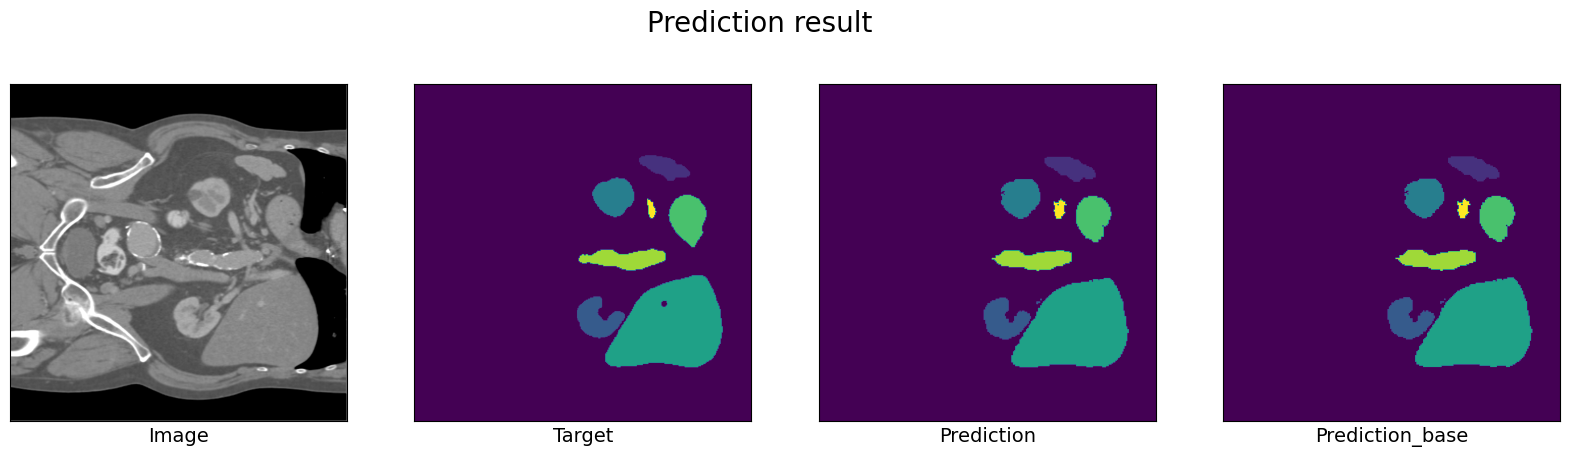

In [ ]:
pre_processing = Compose([
    LoadImage(),
    EnsureChannelFirst(),
    Resize(spatial_size=[img_size[0], img_size[1]], mode = "nearest"),
    ScaleIntensityRange(a_min=-350, a_max=400, b_min=0.0, b_max=1.0, clip=True),
    EnsureChannelFirst(),
    EnsureType()
])

threshold = 0.5
post_processing = Compose([
    Activations(sigmoid=True),
    AsDiscrete(argmax=False, threshold=threshold),
])

target, pred_image = validator.inference(json_name, pre_processing, post_processing, transformations)

## **Запуск исполняемого файла**

In [ ]:
json_data = validator.read_dataset_json(json_name)
paths = rand.choice(json_data["test"])
img_path, lbl_path = paths["image"], paths["label"]
model_path = os.path.join(base_path, save_weights_path, "best_val_dice_0.7954000234603882_epoch_90.pth")
result_path = "/content/drive/MyDrive/Work_projects/VisionLabs/data/infers"

In [ ]:
result = subprocess.run(["python", "/content/drive/MyDrive/Work_projects/VisionLabs/main.py",
                "--model_path", model_path,
                "--test_data_path", img_path,
                '--save_result_path', result_path], capture_output=True, text=True)

In [ ]:
print("stderr:", result.stderr)

stderr: 2024-04-18 00:50:54.699148: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-18 00:50:54.699205: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-18 00:50:54.700644: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-18 00:50:56.236409: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT



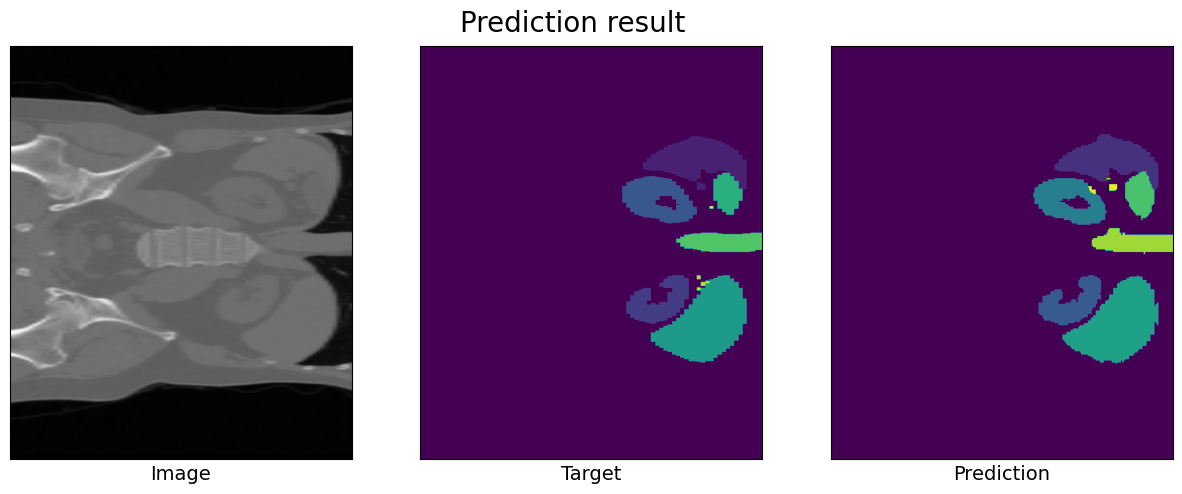

In [ ]:
ncols = 3
nrows = 1
base_img = np.load(img_path)
target = np.load(lbl_path)
pred_img = np.load("/content/drive/MyDrive/Work_projects/VisionLabs/data/infers/result.npy")
fig, ax = plt.subplots(nrows = nrows, ncols = ncols, figsize=(ncols*5, nrows*6))
fig.suptitle("Prediction result", size=20, y=0.9)
ax[0].imshow(base_img, cmap="gray")
ax[0].axes.xaxis.set_ticks([]) # инициализация тиков и меток оси пустым списком
ax[0].get_yaxis().set_visible(False)
ax[0].set_xlabel(f"Image", size=14)
ax[1].imshow(target)
ax[1].axes.xaxis.set_ticks([]) # инициализация тиков и меток оси пустым списком
ax[1].get_yaxis().set_visible(False)
ax[1].set_xlabel(f"Target", size=14)
ax[2].imshow(pred_img)
ax[2].axes.xaxis.set_ticks([]) # инициализация тиков и меток оси пустым списком
ax[2].get_yaxis().set_visible(False)
ax[2].set_xlabel(f"Prediction", size=14)

plt.show()

# **6.) Отчёт по работе**

> **1.)  Анализ данных:**
>
> *   Исходные срезы имеют совершенно различные пропорции.
> *   На большинствве изображений нет полного набора необходимых классов.
> *   Фон на изображениях занимает значительную часть.

---

> **2.)  Предобработка данных:**
>
> *   Для увеличения контрастности значения интесивности были обрезаны  в гарницах отрезка [-350; 400], а затем приведены к диапазону [0; 1].
> *   Метки исходных 13 классов были сокращены до требуемых 8 (с учётом фона).
> *   Изначально в качестве механизма приведения всех изображений к одному формату мною было выбрано обрезание фона и случайное вырезание прямоугольников размером (192, 160), так как этот размер является наибольшим из возможных размеров, стороны которого кратны 32. Здесь я столкнулся с некоторыми проблема. Пришлось отказаться от обрезания фона, так как на некоторых изображениях это оперция пораждала пустые тензоры (видимо из-за того, что на этих изображениях присутствовал только фон). Тем не менее это не помогло при обучении. Модель (я выбрал Swin Unetr) совсем не обучалась на обрезанных сканах. Могу предположить, что это происходило из-за потери большого количества контекстной информации, так как выбранный мною размер (192, 160) был гораздо меньше среднего размера сканов - (500, 500). Таким образом я решил использовать метод monai.transforms.Resize для приведения всех изображений к формату (256, 256).
> *   Для увеличения разнообразия мною было использовано случайное симметричное отображение вдоль обоих измерений.

---

> **3.)  Функция ошибки и метрика качества:**
>
> *   В качестве функции ошибки и метрики качества изначально мною были взяты DiceLoss и DiceMetric соответственно.
> *   Поначалу обучение не приносило положительных результатов, но затем я исключил фон из расчёта функции ошибки, и модель стала акцентировать внимание на сегментации классов.

---

> **4.)  Процесс обучения:**
>
> *   В ходе обучения всё сильнее начинало прослеживаться разница в точности предсказаний между отдельными классами. Dice коэффициент для печени и селезёнки превышал 0.8, подходил к 0.9, в то время как для поджелудочной железы - не доходил и до 0.6. Для других классов в среднем было - 0.76.
> *   В определённый момент модель резко начинала терять в качестве, причём ошибка продолжала падать. Выполнив предсказания, я обнаружил, что модель практически полностью стала игноривать поджелудочную железу. Думаю, это происходило из-за дисбаланса классов.
> *   Чтобы избежать дисбаланса я решил сначала использовать в качестве функции ошибки Dice и перекрёстную энтропию, но это не привело к хорошим результатам, модель всё равно начинала ломаться. Тогда я решил использовать взвешенный DiceLoss. Веса я взял обратно пропорционально dice метрике в 5-й степене, полученной при оценке модели на тестовом наборе данных после 65-ти эпох обучения. Надо сказать, что после этого модель перестала ломаться, но точность не увеличивалась, а так и осталась на уровне 0.79 на отложенной выборке.
> *   Основной трудностью для модели оказалась сегментация поджелудочной железы, что вызвано, думаю, её небольшими размерами по сравнению с другими органами и расположением.

---

> **5.)  Идеи увеличения качества:**
>
> *   Думаю, можно было бы увеличить имеющуюся выборку срезами из датасета AMOS22, так как там всего 15 различных классов, в то время как в TotalSegmentator более 100.
> *   Можно попробовать обучить модель на гораздо большее число классов, чтобы никакие внутренние органы не отмечать в качестве фона. Таким обрахом модель будет учиться полностью выделять внутренние структуры, а затем можно было бы выбирать интересующие нас.
> *   Интересной идеей мне представляется реализовать модель наподобие описанной в данной статье (https://www.researchgate.net/publication/365047182_Brain_tumor_segmentation_based_on_the_fusion_of_deep_semantics_and_edge_information_in_multimodal_MRI). Суть в том, чтобы выделить карты границ всех органов и функцию ошибки подвязать не только на DiceLoss, но и границы органов.
> *   Основная проблема заключается в сегментации поджелудочной железы. Думаю, можно было бы попробовать сегментировать её вместе с желудком, а затем обучить дополнительную модель отделять поджелудочную железу от желудка.

---

> **6.)  Разметка:**
>
> *   Фон - 0
> *   Селезёнка - 1
> *   Правая почка - 2
> *   Левая почка - 3
> *   Печень - 4
> *   Желудок - 5
> *   Аорта - 6
> *   Поджелудочная железа - 7
